In [1]:
import torch
from torch.autograd import Variable
import os
import torch.nn as nn
from datetime import datetime
from ResUNet import ResUNet
from dataloader import IDRiD_Dataset
import torch.nn.functional as F
import numpy as np
import logging
import time
import random
import csv
import random
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [2]:
segmentation_dir = './dataset/1. Original Images/a. Training Set'
mask_dir = './dataset/2. All Segmentation Groundtruths/a. Training Set'
image_dir = './classification_dataset/1. Original Images/a. Training Set'
csv_dir = './classification_dataset/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv'

dataset = IDRiD_Dataset(
    image_root=segmentation_dir,
    csv_path=csv_dir,
    mask_root=mask_dir,
    trainsize=224,
    augmentations=True,
    mask_type='multichannel'
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

Using augmentations


In [4]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def train_with_routing(model, train_loader, val_loader, epochs, device, log_dir='logs'):
    set_seed(42)

    seg_loss_fn = nn.BCEWithLogitsLoss()
    cls_loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    os.makedirs(log_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    log_file = os.path.join(log_dir, f'training_log_{timestamp}.csv')
    model_dir = os.path.join(log_dir, 'checkpoints_new')
    os.makedirs(model_dir, exist_ok=True)

    with open(log_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            'epoch', 'train_loss', 'val_loss',
            'seg_loss', 'cls_loss',
            'seg_weight', 'cls_weight',
            'seg_samples', 'cls_samples'
        ])

    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        epoch_seg_loss = 0
        epoch_cls_loss = 0
        seg_samples_count = 0
        cls_samples_count = 0

        for images, labels, masks in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            masks = masks.float().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            routing_weights = outputs['routing_weights']

            seg_loss = cls_loss = torch.tensor(0., device=device)
            seg_samples = [i for i, out in enumerate(outputs['segmentation']) if out is not None]
            cls_samples = [i for i, out in enumerate(outputs['classification']) if out is not None]

            # Segmentation
            if seg_samples:
                seg_targets = masks[seg_samples]
                ds_preds_list = []

                for head_idx in range(5):
                    head_preds = [outputs['segmentation'][i][head_idx] for i in seg_samples]
                    head_preds = torch.cat(head_preds, dim=0)
                    ds_preds_list.append(head_preds)

                seg_preds = torch.stack(ds_preds_list, dim=0).sum(dim=0)
                seg_loss = seg_loss_fn(seg_preds, seg_targets)
                seg_samples_count += len(seg_samples)

            # Classification
            if cls_samples:
                cls_preds = torch.cat([outputs['classification'][i] for i in cls_samples], dim=0)
                cls_targets = labels[cls_samples]
                cls_loss = cls_loss_fn(cls_preds, cls_targets)
                cls_samples_count += len(cls_samples)

            seg_weight = routing_weights[seg_samples, 1].mean().item() if seg_samples else 0.0
            cls_weight = routing_weights[cls_samples, 0].mean().item() if cls_samples else 0.0

            loss = seg_weight * seg_loss + cls_weight * cls_loss
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            epoch_seg_loss += seg_loss.item() if seg_samples else 0
            epoch_cls_loss += cls_loss.item() if cls_samples else 0

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels, masks in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                masks = masks.float().to(device)

                outputs = model(images)
                routing_weights = outputs['routing_weights']

                seg_loss = cls_loss = torch.tensor(0., device=device)
                seg_samples = [i for i, out in enumerate(outputs['segmentation']) if out is not None]
                cls_samples = [i for i, out in enumerate(outputs['classification']) if out is not None]

                if seg_samples:
                    seg_targets = masks[seg_samples]
                    ds_preds_list = []
                    for head_idx in range(5):
                        head_preds = [outputs['segmentation'][i][head_idx] for i in seg_samples]
                        head_preds = torch.cat(head_preds, dim=0)
                        ds_preds_list.append(head_preds)
                    seg_preds = torch.stack(ds_preds_list, dim=0).sum(dim=0)
                    seg_loss = seg_loss_fn(seg_preds, seg_targets)

                if cls_samples:
                    cls_preds = torch.cat([outputs['classification'][i] for i in cls_samples], dim=0)
                    cls_targets = labels[cls_samples]
                    cls_loss = cls_loss_fn(cls_preds, cls_targets)

                seg_weight = routing_weights[seg_samples, 1].mean().item() if seg_samples else 0.0
                cls_weight = routing_weights[cls_samples, 0].mean().item() if cls_samples else 0.0

                val_loss += (seg_weight * seg_loss + cls_weight * cls_loss).item()

        train_loss_avg = epoch_train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)
        seg_loss_avg = epoch_seg_loss / max(1, seg_samples_count)
        cls_loss_avg = epoch_cls_loss / max(1, cls_samples_count)

        # Saveing model checkpoints
        torch.save(model.state_dict(), os.path.join(model_dir, f'epoch_{epoch+1}.pth'))

        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            torch.save(model.state_dict(), os.path.join(model_dir, 'best_model.pth'))

       
        with open(log_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                epoch + 1,
                round(train_loss_avg, 6),
                round(val_loss_avg, 6),
                round(seg_loss_avg, 6),
                round(cls_loss_avg, 6),
                round(seg_weight, 4),
                round(cls_weight, 4),
                seg_samples_count,
                cls_samples_count
            ])

        
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {train_loss_avg:.4f} | Val Loss: {val_loss_avg:.4f}")
        print(f"  Seg Loss: {seg_loss_avg:.4f} | Cls Loss: {cls_loss_avg:.4f}")
        print(f"  Seg Weight: {seg_weight:.4f} | Cls Weight: {cls_weight:.4f}")
        print(f"  Seg Samples: {seg_samples_count} | Cls Samples: {cls_samples_count}")
        print("-" * 60)


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResUNet(in_channels=3, num_classes=5).to(device)
train_with_routing(model, train_loader, val_loader, epochs=50, device=device)

Epoch 1/50:
  Train Loss: 1.2350 | Val Loss: 1.0706
  Seg Loss: 0.2163 | Cls Loss: 0.0846
  Seg Weight: 0.5393 | Cls Weight: 0.5330
  Seg Samples: 6 | Cls Samples: 37
------------------------------------------------------------
Epoch 2/50:
  Train Loss: 1.1973 | Val Loss: 1.1403
  Seg Loss: 0.1706 | Cls Loss: 0.0858
  Seg Weight: 0.5481 | Cls Weight: 0.5257
  Seg Samples: 7 | Cls Samples: 36
------------------------------------------------------------
Epoch 3/50:
  Train Loss: 1.1542 | Val Loss: 1.1201
  Seg Loss: 0.1656 | Cls Loss: 0.0840
  Seg Weight: 0.5440 | Cls Weight: 0.5278
  Seg Samples: 7 | Cls Samples: 36
------------------------------------------------------------
Epoch 4/50:
  Train Loss: 1.0301 | Val Loss: 1.1420
  Seg Loss: 0.1900 | Cls Loss: 0.0756
  Seg Weight: 0.5285 | Cls Weight: 0.5506
  Seg Samples: 4 | Cls Samples: 39
------------------------------------------------------------
Epoch 5/50:
  Train Loss: 1.0234 | Val Loss: 1.1478
  Seg Loss: 0.1045 | Cls Loss: 0.080

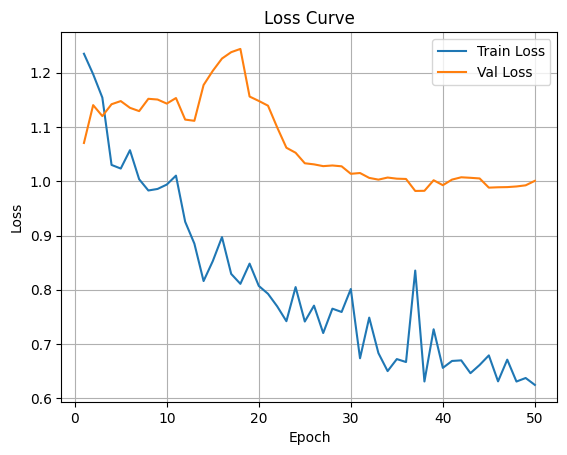

In [13]:
log_file = './logs/training_log_20250706_185931.csv' 
df = pd.read_csv(log_file)


plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
plt.plot(df['epoch'], df['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
segmentation_dir = './dataset/1. Original Images/b. Testing Set'
mask_dir = './dataset/2. All Segmentation Groundtruths/b. Testing Set'
image_dir = './classification_dataset/1. Original Images/b. Testing Set'
csv_dir = './classification_dataset/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv'

dataset = IDRiD_Dataset(
    image_root=segmentation_dir,
    csv_path=csv_dir,
    mask_root=mask_dir,
    trainsize=224,
    augmentations=False,
    mask_type='multichannel'
)

test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

No augmentations


In [10]:
def evaluate_model(model, test_loader, device, num_classes=5):
    model.eval()
    
    # Classification metrics
    all_preds = []
    all_labels = []
    
   
    dice_scores = {i: [] for i in range(num_classes)}
    iou_scores = {i: [] for i in range(num_classes)}

    
    total_cls_samples = 0
    total_seg_samples = 0
    
    with torch.no_grad():
        for images, labels, masks in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            masks = masks.float().to(device) 
            
            outputs = model(images)
            
            
            cls_samples = [i for i, out in enumerate(outputs['classification']) if out is not None]
            total_cls_samples += len(cls_samples)
            
           
            if cls_samples:
                cls_preds = torch.cat([outputs['classification'][i] for i in cls_samples], dim=0)
                cls_labels = labels[cls_samples]
                
                cls_preds = torch.argmax(cls_preds, dim=1)
                all_preds.extend(cls_preds.cpu().numpy())
                all_labels.extend(cls_labels.cpu().numpy())
            
           
            seg_samples = [i for i, out in enumerate(outputs['segmentation']) if out is not None]
            total_seg_samples += len(seg_samples)

            if seg_samples:
                
                seg_preds = torch.sigmoid(outputs['segmentation'][seg_samples[0]][3])  # [B, 1, H, W]
                seg_preds = seg_preds.repeat(1, num_classes, 1, 1) > 0.5  # [B, C, H, W]
                
                seg_masks = masks[seg_samples]
                
                for class_idx in range(num_classes):
                    pred_mask = seg_preds[:, class_idx]  # [B, H, W]
                    true_mask = seg_masks[:, class_idx]  # [B, H, W]
                    
                    
                    intersection = (pred_mask * true_mask).sum(dim=(1,2))
                    union = pred_mask.sum(dim=(1,2)) + true_mask.sum(dim=(1,2))
                    dice = (2 * intersection + 1e-6) / (union + 1e-6)
                    dice_scores[class_idx].extend(dice.cpu().numpy())
                    
                    
                    iou = (intersection + 1e-6) / (union - intersection + 1e-6)
                    iou_scores[class_idx].extend(iou.cpu().numpy())

    
    print(f"\n Routing Summary:")
    print(f"  → Classification Expert: {total_cls_samples} samples")
    print(f"  → Segmentation Expert:   {total_seg_samples} samples")

    # Classification report
    if all_preds:
        print("\n Classification Report:")
        print(classification_report(all_labels, all_preds, 
                                  target_names=[str(i) for i in range(num_classes)]))
        
        plt.figure(figsize=(8,6))
        cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                      display_labels=[str(i) for i in range(num_classes)])
        disp.plot(cmap='Blues')
        plt.title("Confusion Matrix: multi-task")
        plt.show()
    else:
        print("\n No samples were routed to classification.")

    # Segmentation report
    print("\n Segmentation Metrics:")
    has_seg_results = False
    for class_idx in range(num_classes):
        if dice_scores[class_idx]:
            has_seg_results = True
            print(f"  Class {class_idx}:")
            print(f"    Dice: {np.mean(dice_scores[class_idx]):.4f} ± {np.std(dice_scores[class_idx]):.4f}")
            print(f"    IoU:  {np.mean(iou_scores[class_idx]):.4f} ± {np.std(iou_scores[class_idx]):.4f}")
    
    if not has_seg_results:
        print(" No samples were routed to segmentation.")

    return {
        'classification': {
            'preds': all_preds,
            'labels': all_labels,
            'report': classification_report(all_labels, all_preds, output_dict=True) if all_preds else None
        },
        'segmentation': {
            'dice_scores': dice_scores,
            'iou_scores': iou_scores
        }
    }



 Routing Summary:
  → Classification Expert: 22 samples
  → Segmentation Expert:   5 samples

 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00         3
           2       0.56      0.71      0.62         7
           3       0.18      1.00      0.31         2
           4       0.00      0.00      0.00         2

    accuracy                           0.32        22
   macro avg       0.15      0.34      0.19        22
weighted avg       0.19      0.32      0.23        22



<Figure size 800x600 with 0 Axes>

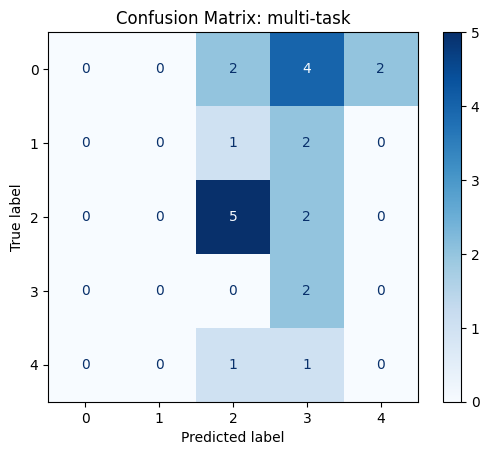


 Segmentation Metrics:
  Class 0:
    Dice: 0.0000 ± 0.0000
    IoU:  0.0000 ± 0.0000
  Class 1:
    Dice: 0.0001 ± 0.0001
    IoU:  0.0000 ± 0.0000
  Class 2:
    Dice: 0.0002 ± 0.0002
    IoU:  0.0001 ± 0.0001
  Class 3:
    Dice: 0.0000 ± 0.0000
    IoU:  0.0000 ± 0.0000
  Class 4:
    Dice: 0.0000 ± 0.0001
    IoU:  0.0000 ± 0.0000


In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResUNet(in_channels=3, num_classes=5).to(device)
model.load_state_dict(torch.load('logs/checkpoints_new/best_model.pth'))
model.eval().to(device)

results = evaluate_model(model, test_loader, device)

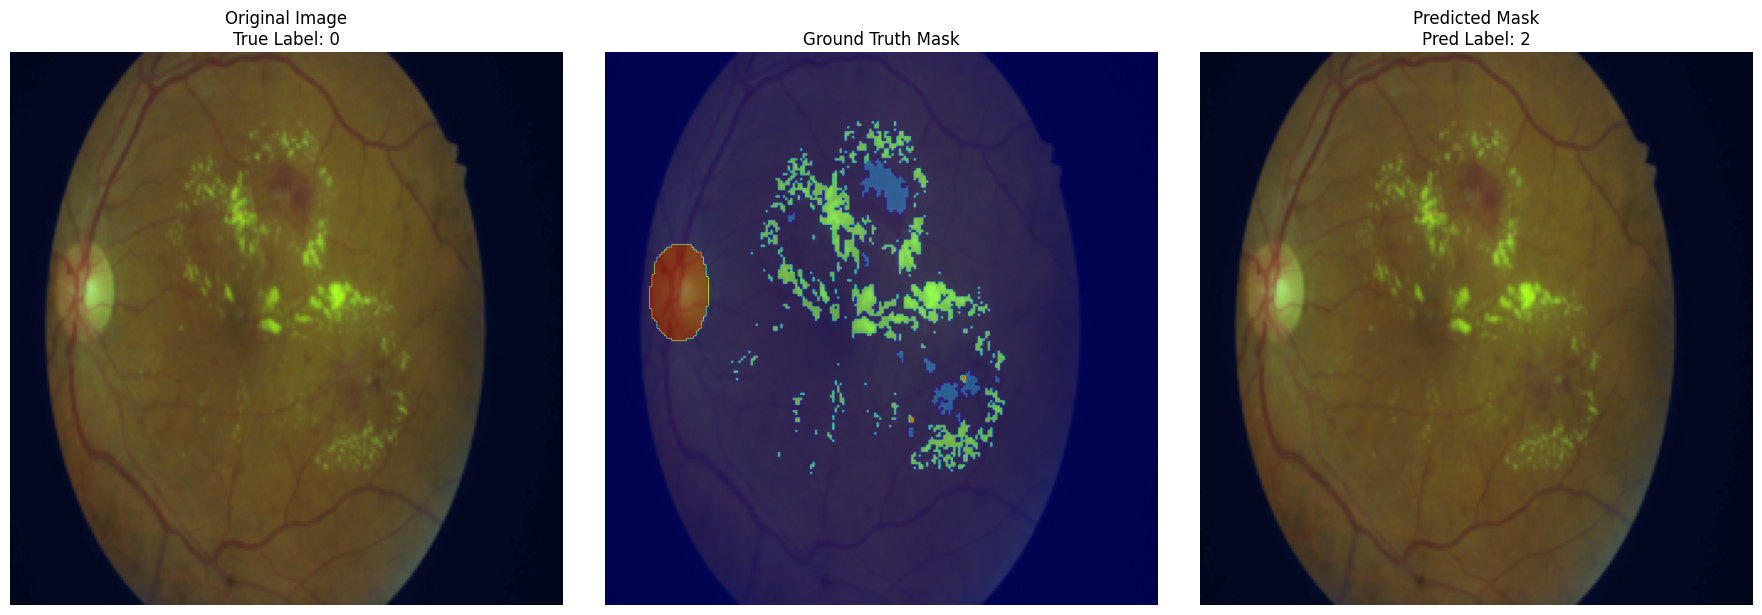

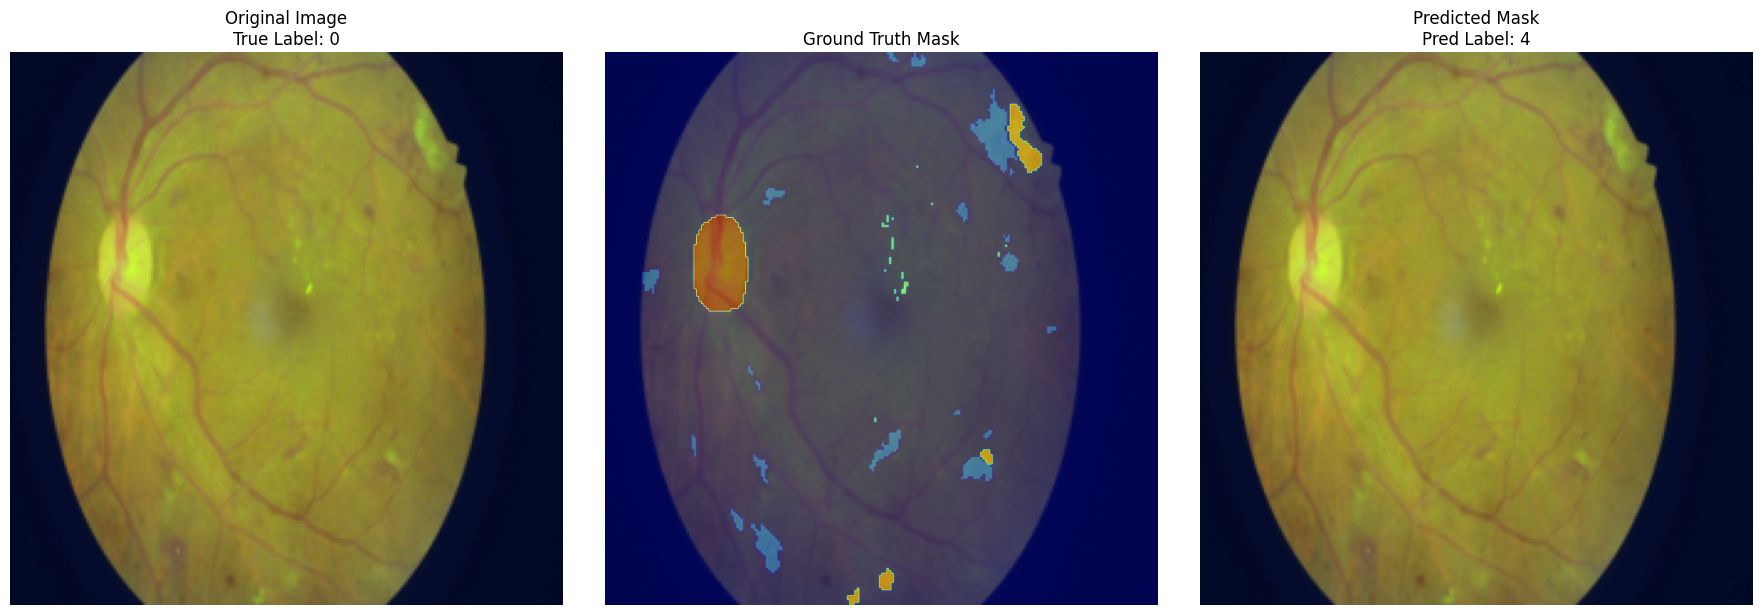

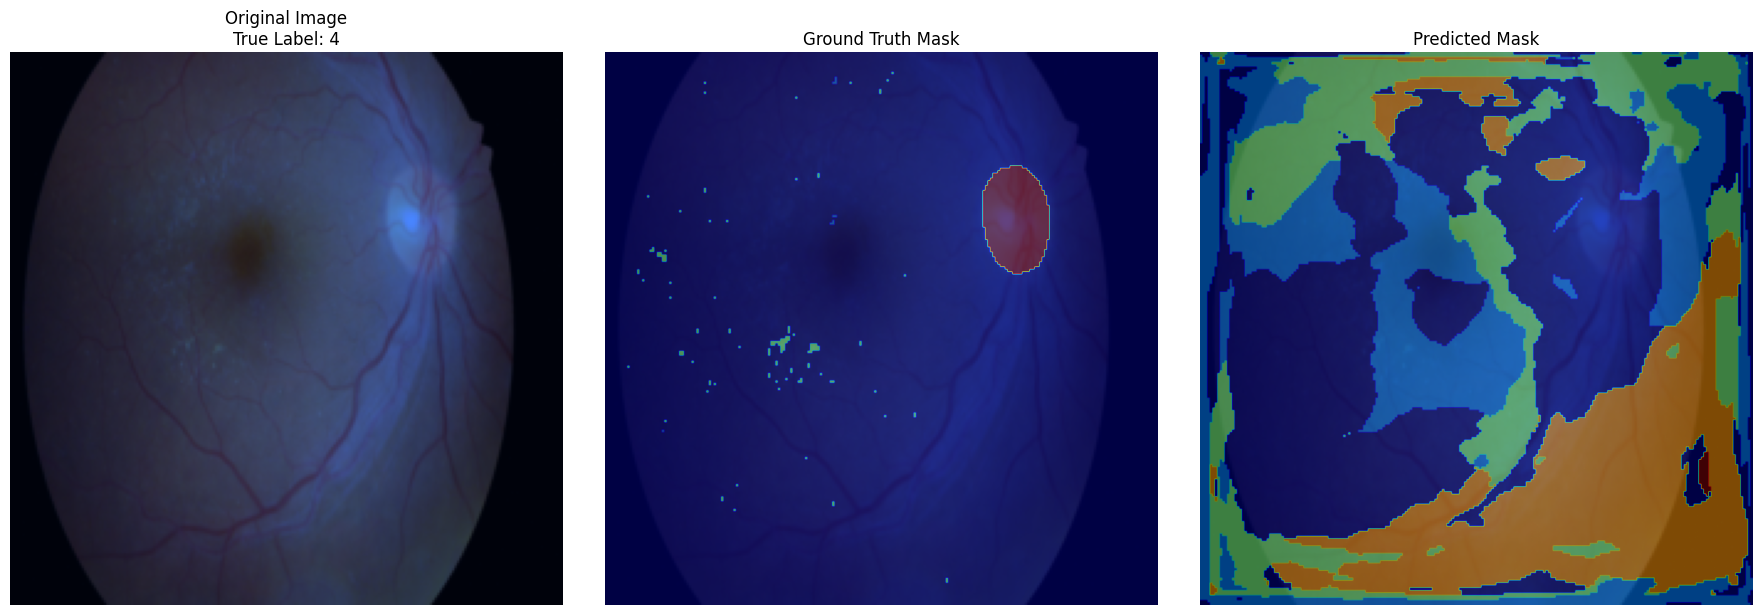

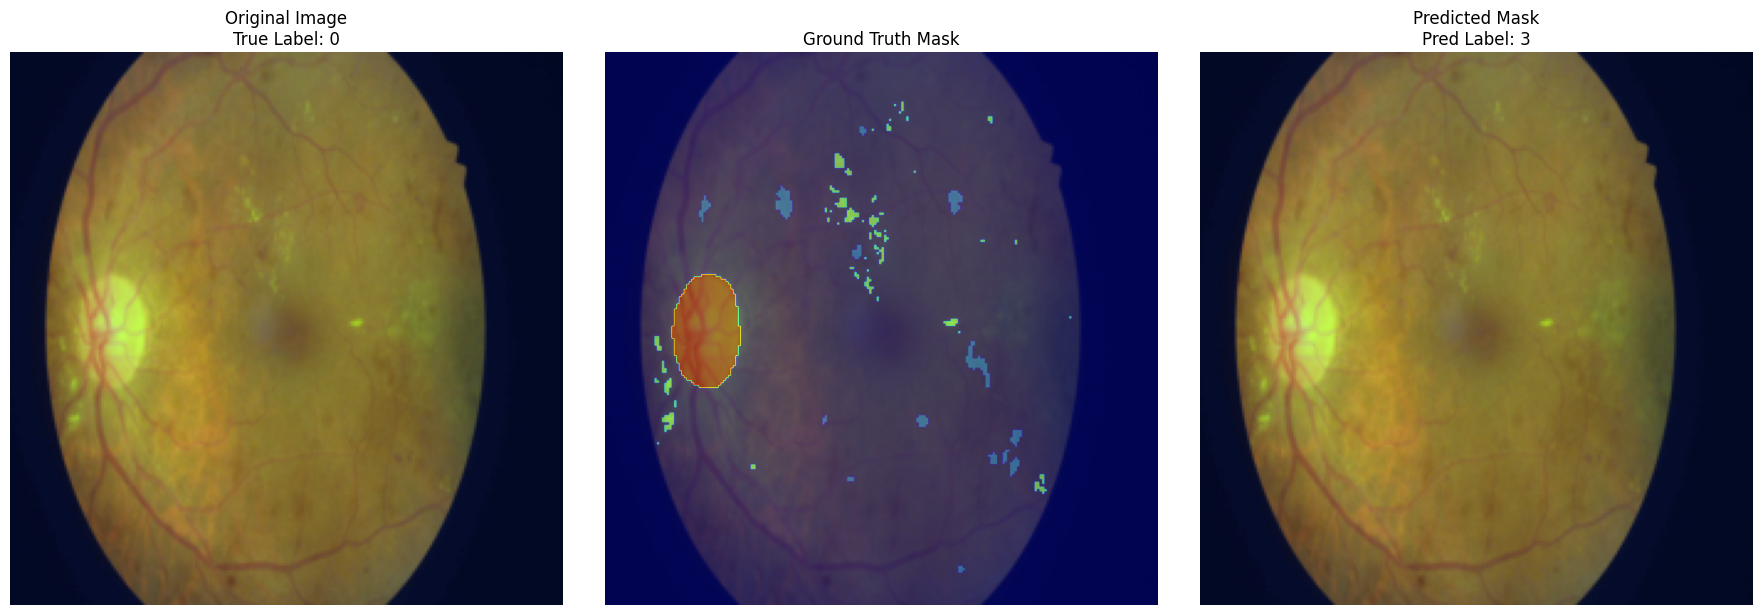

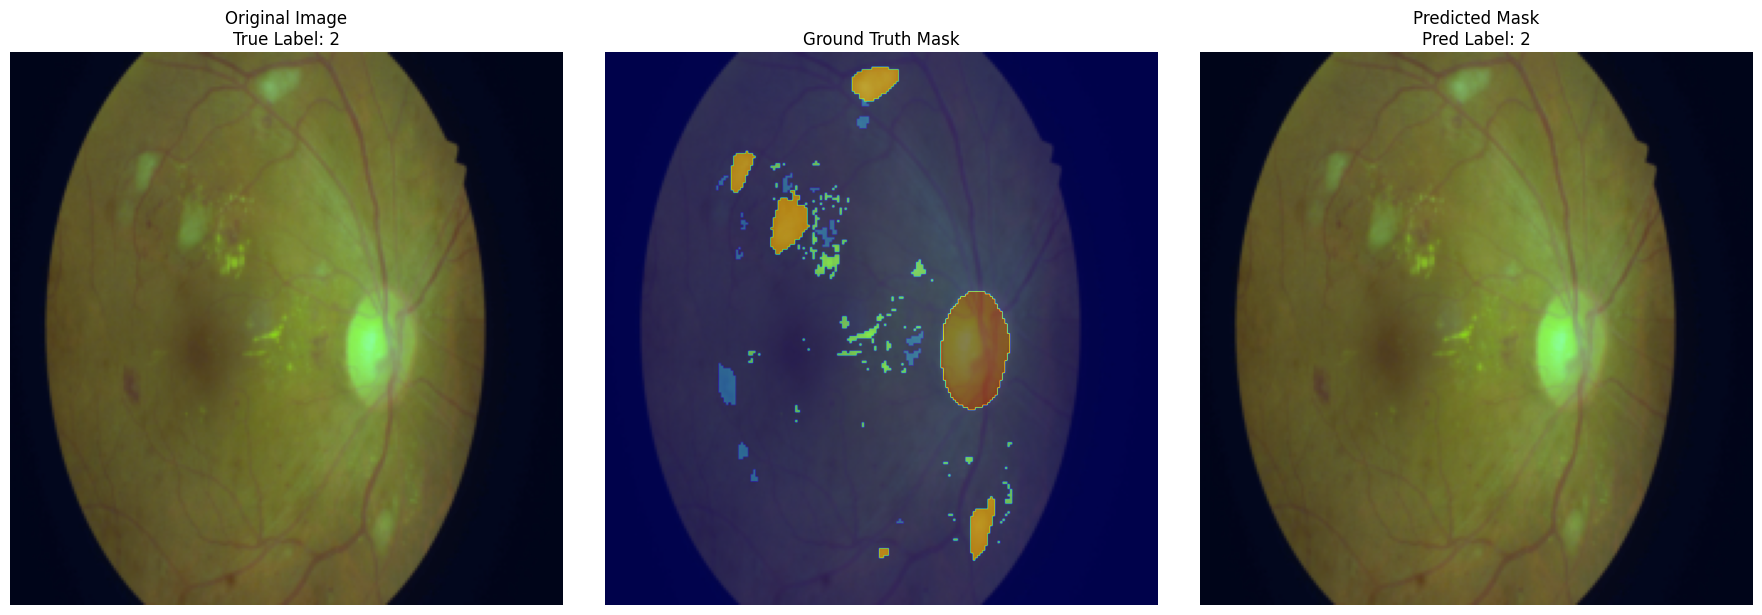

In [24]:
def visualize_predictions(model, test_loader, device, num_samples=5, num_classes=5):
    model.eval()
    
    
    dataset = test_loader.dataset
    
    for i in range(min(num_samples, len(dataset))):  
        image, label, true_mask = dataset[i]
        image = image.unsqueeze(0).to(device)  # Add batch dimension
        
        with torch.no_grad():
            outputs = model(image)
            
          
            pred_label = None
            if outputs['classification'] is not None and outputs['classification'][0] is not None:
                pred_label = torch.argmax(outputs['classification'][0], dim=1).item()
            
            pred_mask = None
            if outputs['segmentation'] is not None and outputs['segmentation'][0] is not None:
               
                pred_mask = torch.sigmoid(outputs['segmentation'][0][3])  # [1, 1, H, W]
                pred_mask = pred_mask.repeat(1, num_classes, 1, 1) > 0.5  # [1, 5, H, W]
        
       
        image_np = image.squeeze().permute(1, 2, 0).cpu().numpy()
        image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
        
        
        true_mask_np = true_mask.permute(1, 2, 0).cpu().numpy() if true_mask is not None else None
        pred_mask_np = pred_mask.squeeze(0).permute(1, 2, 0).cpu().numpy() if pred_mask is not None else None
        
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Original image
        axes[0].imshow(image_np)
        axes[0].set_title(f"Original Image\nTrue Label: {label.item()}")
        axes[0].axis('off')
        
        # Ground truth mask
        axes[1].imshow(image_np)
        if true_mask_np is not None:
            axes[1].imshow(np.argmax(true_mask_np, axis=-1), alpha=0.5, cmap='jet', vmin=0, vmax=num_classes-1)
        axes[1].set_title("Ground Truth Mask")
        axes[1].axis('off')
        
        # Predicted mask
        axes[2].imshow(image_np)
        if pred_mask_np is not None:
           # one-hotencoding for classes
            pred_class_indices = np.argmax(pred_mask_np, axis=-1)
            axes[2].imshow(pred_class_indices, alpha=0.5, cmap='jet', vmin=0, vmax=num_classes-1)
        title = "Predicted Mask"
        if pred_label is not None:
            title += f"\nPred Label: {pred_label}"
        axes[2].set_title(title)
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()


visualize_predictions(model, test_loader, device, num_samples=5)